In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        #バイアス、重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        #np.random.randnは正規分布
        
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        #2層にわたり認識処理
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2) #出力層の活性化関数はソフトマックス関数
        return y
       
    # x:入力データ, t:教師データ
    #損失関数
    def loss(self, x, t):
        y = self.predict(x)
       #交差エントロピー誤差を利用
        return cross_entropy_error(y, t)
    
    #精度
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        #axis=1は行ごとに処理
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    #勾配(損失関数の各種パラメータでの偏微分)計算
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t) #損失関数
        
        grads = {} #勾配の辞書初期化
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    #勾配の別の求め方
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

サンプルコードに適宜コメントを入れて理解の助けとした。
gradientについてはよくわからなかったが、参考文献1によると次章で登場する内容なので、ここの理解は次回しっかり行う。

In [6]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)
#normalizeは正規化のフラグ、one_hot_labelはone_hot表現(正解のみ1)のフラグ

#確認用
#print(x_train.shape) #(60000, 784)
#print(t_train.shape) #(60000, 10)
#print(x_test.shape) #(10000, 784)
#print(t_test.shape) #(10000, 10)

train_loss_list =[]

#ネットワークの初期化
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)

#パラメータ
iters_num = 10000 #自分で設定
train_size = x_train.shape[0] #60000
batch_size = 100 #自分で設定
learning_rate = 0.5 #自分で設定

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size) #iterationをランダムに取得(60000→100)
    x_batch = x_train[batch_mask] #圧縮した訓練データ(バッチ)を取得
    t_batch = t_train[batch_mask] #圧縮したテストデータ(バッチ)を取得
    
    #確認用
    #print(batch_mask) #iterationのリストが表示
    #print(x_batch) #0.が多数のリスト
    #print(x_batch.shape) #(60000,784) -> (100,784)
    #print(t_batch) #[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]のように各行に1が一つのリストが出力
    #print(t_batch.shape) #(60000,10) -> (100,10)
    
    #勾配の計算
    grad = net.numerical_gradient(x_batch, t_batch)
    
    #重み、バイアスの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= learning_rate*grad[key]
    
    #損失関数の推移記録
    loss = net.loss(x_batch, t_batch)
    train_loss_list.append(loss)

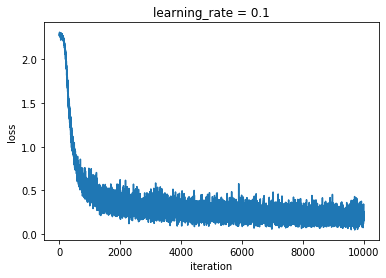

In [5]:
import matplotlib.pylab as plt

#学習率0.1
x = np.arange(0, 10000, 1)
y = train_loss_list
y = np.array(y) #リストから配列へ
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('learning_rate = 0.1')
plt.plot(x, y)
plt.show()

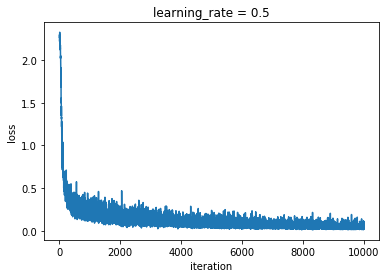

In [7]:
#学習率0.5
x = np.arange(0, 10000, 1)
y = train_loss_list
y = np.array(y)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('learning_rate = 0.5')
plt.plot(x, y)
plt.show()

ソースコード内に確認用としてprintで種々の値を確認しながら実装を行った。
実装に際し、バッチについての理解がかなり深まった。
実行の際は学習率learning_rateの値を0.1と0.5にして試した。
学習率が高いほど収束するのが速いことが確認できた。グラフにして見るとより分かりやすくなった。

次に精度の評価を行う。
実行時のコードを変更する。

In [9]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)
#normalizeは正規化のフラグ、one_hot_labelはone_hot表現(正解のみ1)のフラグ

train_loss_list =[]
train_acc_list = []
test_acc_list = []

#iteration/1 epoch
iter_per_epoch = max(train_size / batch_size, 1) #60000/100=600回繰り返し

#ネットワークの初期化
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)

#パラメータ
iters_num = 10000 #自分で設定
train_size = x_train.shape[0] #60000
batch_size = 100 #自分で設定
learning_rate = 0.5 #自分で設定

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size) #iterationをランダムに取得(60000→100)
    x_batch = x_train[batch_mask] #圧縮した訓練データ(バッチ)を取得
    t_batch = t_train[batch_mask] #圧縮したテストデータ(バッチ)を取得
    
    #確認用
    #print(batch_mask) #iterationのリストが表示
    #print(x_batch) #0.が多数のリスト
    #print(x_batch.shape) #(60000,784) -> (100,784)
    #print(t_batch) #[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]のように各行に1が一つのリストが出力
    #print(t_batch.shape) #(60000,10) -> (100,10)
    
    #勾配の計算
    grad = net.numerical_gradient(x_batch, t_batch)
    
    #重み、バイアスの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= learning_rate*grad[key]
    
    #損失関数の推移記録
    loss = net.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0: #i % 600 ; 1epochごとに呼ばれる
        #精度accの計算
        train_acc = net.accuracy(x_train, t_train)
        test_acc = net.accuracy(x_test, t_test)
        #精度の推移記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

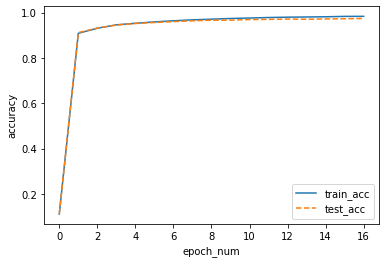

In [19]:
x = np.arange(0, iters_num / iter_per_epoch, 1)
#確認用
#print(len(train_acc_list)) #17
#print(len(test_acc_list)) #17
#list -> array
y_train_acc = np.array(train_acc_list)
y_test_acc = np.array(test_acc_list)
#
plt.plot(x, y_train_acc, label = 'train_acc')
plt.plot(x, y_test_acc, linestyle = "--", label = 'test_acc')

plt.xlabel('epoch_num')
plt.ylabel('accuracy')
plt.legend()
plt.show()


これはエポックと精度の関係を表すグラフであり、実線(青)が訓練データ,波線(オレンジ)がテストデータを表している。
ほとんど重なっているのが分かる。また、エポックが大きくなる、すなわち学習が進んでいくと、わずかにtrain_accのほうがaccuracyが大きくなっている。このことから若干の過学習が起きていると考えられる。2つのグラフの乖離が始まるのがepoch_num=8の付近であるので、繰り返しはepoch_num=8すなわち600*8≒5000回程度がよいと考えられる。

提出前になり、サンプルコード二つめがあるのに気付いた。そのため実行処理はほとんど自力で作ることとなったが、結果的には良かったと思う。自分で考えて書く場合、理解できていないところは記述できないので、分からないところがほとんどなくなったと思う。
今回登場したgradientについて次回しっかり理解したいと思う。

数値微分について試した。

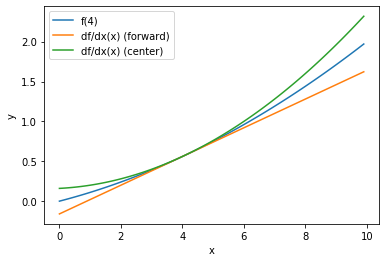

In [20]:
import numpy as np

def f(x):
    return( 0.01*x**2 + 0.1*x )

def diff_1(f, x):
    h = 1e-4
    return( ( f(x + h) - f(x) ) / h )

def diff_2(f, x):
    h = 1e-4
    return( ( f(x + h) - f(x - h) ) / (2*h) )

x = np.arange(0.0, 10.0, 0.1)
y = f(x)
a1 = diff_1(f, 4)
y1 = a1*(x - 4) + f(4) 
a2 = diff_2(f, x)
y2 = a2*(x - 4) + f(4)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, label = 'f(4)')
plt.plot(x, y1, label = "df/dx(x) (forward)")
plt.plot(x, y2, label = "df/dx(x) (center)")
plt.legend()
plt.show()



グラフを見ると,オレンジの直線が前方差分であり、青が中心差分である。

三次元グラフ描画の練習
参考文献2を参考にした。

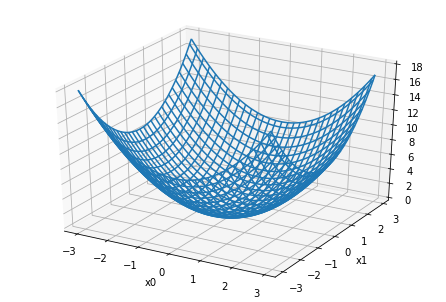

In [21]:
from mpl_toolkits.mplot3d import Axes3D

def f2(x0, x1):
    return x0**2 + x1**2

x0 = np.arange(-3, 3, 0.1)
x1 = np.arange(-3, 3, 0.1)
X0, X1 = np.meshgrid(x0, x1)
Y = f2(X0, X1)
flg = plt.figure()
ax = Axes3D(flg)

ax.set_xlabel('x0')
ax.set_ylabel('x1')

ax.plot_wireframe(X0, X1, Y)
plt.show()

参考文献
1. 【ゼロから作るDeep Learning】4章 ニューラルネットワークの学習

2. https://qiita.com/orange_u/items/8a1e285a45093857aef7
三次元グラフの描画方法について調べるのに利用